# <center> **FACIAL EMOTION RECOGNITION**
    
# 1. Introduction

In this competition, we will build a classifier algorithm that categorizes facial expressions of humans in gray-scale portraits into one of four emotion cagetories: anger, happiness, disgust, sadness 
    
    
Before we get started, we will answer the following questions:
    
**Where do the data come from, and to which population will results generalize?**
    
> The dataset is called CKPlus. It is a  widely used facial expression database used for research in the field of facial expression analysis and computer vision. (S. Li, W. Deng, Deep facial expression recognition: a survey. IEEE Trans. Affect. Comput. 13, 1195–1215 (2020)). It consists of both posed and spontaneous expressions from a total of 123 subjects with diverse ethnic backgrounds aged between 18-50 years. The pictures were taken under controlled lighting conditions with subjects seated in front of a camera. Researchers coded expressed emotion , the intensity of the emotion, and the location of facial landmarks. They included seven different emotions: Anger, Contempt, Disgust, Fear, Happiness, Sadness, Surprise. 
>
> For our project, we only used a subset of the CL+ database. We only distinguished between four different emotions and did not include its intensity. Additionaly, some of the images are repeated, but then shifted, rotated, or both to improve the algorithm. 
>    
> While the datset did include subjects of different ethnicities and age, the generalizability of our results will still be limited. As metioned, the pictures were taken under controlled conditions with consistent and good lighting. This means that our algorithm will probably have difficulties recognizing facial expressions in more "normal", day-to-day pictures. In addition to that, the datapoints are not independent of each other as multiple pictures were taken of each participant. Independence, however, is an important assumption of many algorithms and statistical tests.     

**What are candidate machine learning methods?**

> There is a wide variety of possible algorithms to choose from. These algorithms differ in their levels of flexibility and bias. Possible algorithms sorted from least to most flexible are: 
> Linear Discrimminant Analysis, multinomial logistic regression, Ridge Regression, Lasso Regression, , K-nearest Neighbors, Random Forestn, Support Vector 
> 
> The more flexible a model is, the more it is driven by the training data and will probably achieve a good model fit. The "danger" of highly flexible models is that they *overfit* the training data which would mean that they do not predict future observations well, which is our goal. This is why we chose less flexible (aka more biased) models that make stronger assumptions about the underlying distribution. This might result it a worse model fit, but will likely predict future cases better. 
> This is why we decided on fitting ...

**What is the Bayes' error bound?**

> The Bayes' error bound represents a fundamental theoretical limit on the classification error rate (aka the minimym accuracy) that any algorithm should achieve. Previous research has determined the accuracy of humans when as 67% for disgust, 62% for anger, 80% for happy, 70% for sad. Human accuracy has also been tested for the CK+ database specifically which lead to the confusion matrix shown below and an overall accuracy of 74.4%. <br>
>
>|      | Anger | Disgust | Happy | Sadness |
>|------|-------|---------|-------|---------|
>| Anger   | 23   | 9       | 1     | 0       |
>| Disgust | 6    | 35      | 4     | 2       |
>| Happy   | 4    | 3       | 66    | 0       |
>| Sad     | 9    | 7       | 1     | 10      |
>
> For Machine Learning models the Bayes Error Bound is discussed in: https://www.hindawi.com/journals/cin/2022/8032673/ The reported accuracies for emotion recognition through facial expression range in the experiment have a training accuracy of 100% and a test accuracy of up to 90% for SVM and RF and up to 95% for KNN.
    
    
# 2. Data
    
    
## 2.1 Preparation
    
First, we loaded all necessary libraries, set the working directory and imported all image files. 
    

In [208]:
## loading libraries

suppressMessages(library(tidyverse))
suppressMessages(library(png))
suppressMessages(library(tidytext))
suppressMessages(library(caret))
suppressMessages(library(glmnet))
suppressMessages(library(ggplot2))
suppressMessages(library(gridExtra))
suppressMessages(library(caret))
suppressMessages(library(ggplot2))

In [209]:
## Reading in files

list.files(path = "../input/")


# Show availabe directories
dirs = dir("../input", pattern="[^g]$", recursive=TRUE, include.dirs = TRUE, full.names = TRUE)
# dirs

# Get all image files: file names ending ".png" 
anger   = dir(grep("anger",   dirs, value = TRUE), pattern = "png$", full.names = TRUE)
disgust = dir(grep("disgust", dirs, value = TRUE), pattern = "png$", full.names = TRUE)
happy   = dir(grep("happy",   dirs, value = TRUE), pattern = "png$", full.names = TRUE)
sad     = dir(grep("sad",     dirs, value = TRUE), pattern = "png$", full.names = TRUE)
test_im = dir(grep("test",    dirs, value = TRUE), pattern = "png$", full.names = TRUE)

[1] "bda-2023-facial-expressions"

## 2.2 Loading the data

Next, we loaded the data and created a function to visualize some of the pictures to make sure that everything worked. 

Each imagine is stored in a vector of pixel intensities. Another vector contains the emotion labels for each of the images. In order to save on RAM, the images for this competition are...

* ... gray scale, so we need only one color channel
* ... are only 48 by 48 pixels


In [210]:
# Combine all filenames into a single vector
train_image_files = c(anger, happy, sad, disgust)

# Read in the images as pixel values (discarding color channels)
X = sapply(train_image_files, function(nm) c(readPNG(nm)[,,1])) %>% t() 
y = c(rep("anger", length(anger)), rep("happy", length(happy)), rep("sad", length(sad)), rep("disgust", length(disgust)))

X_test = sapply(test_im, function(nm) c(readPNG(nm)[,,1])) %>% t() 


# Change row and column names of X to something more managable (caret::train requires column names)
rownames(X)      = gsub(".+train/", "", rownames(X))
rownames(X_test) = gsub(".+test/",  "", rownames(X_test))

colnames(X) = colnames(X_test) = paste("p",1:ncol(X), sep="")

                
# Visualization utility function
as_image = function(x, nr=sqrt(length(x))) {opar=par(mar=rep(0,4)); on.exit(par(opar)); image(t(matrix(x,nr))[,nr:1], col = gray(0:255/255),axes=F)}

                # Combine training and test data
X <- rbind(X, X_test)

# Save the indices of the test data
test_indices <- (2538 + 1):nrow(X)

## 2.3 Creating a Test Subset

Lastly, we split the data into a test and training set to evaluate our model's performance using a confusion matrix. 

In [211]:
set.seed(123)

# Create random partition of the data
train_val = caret::createDataPartition(y, p = 0.8, list = FALSE)

# Define training & validation set
train_X = X[train_val, ]
test_X = X[-train_val, ]

train_y = y[train_val]
test_y = y[-train_val]

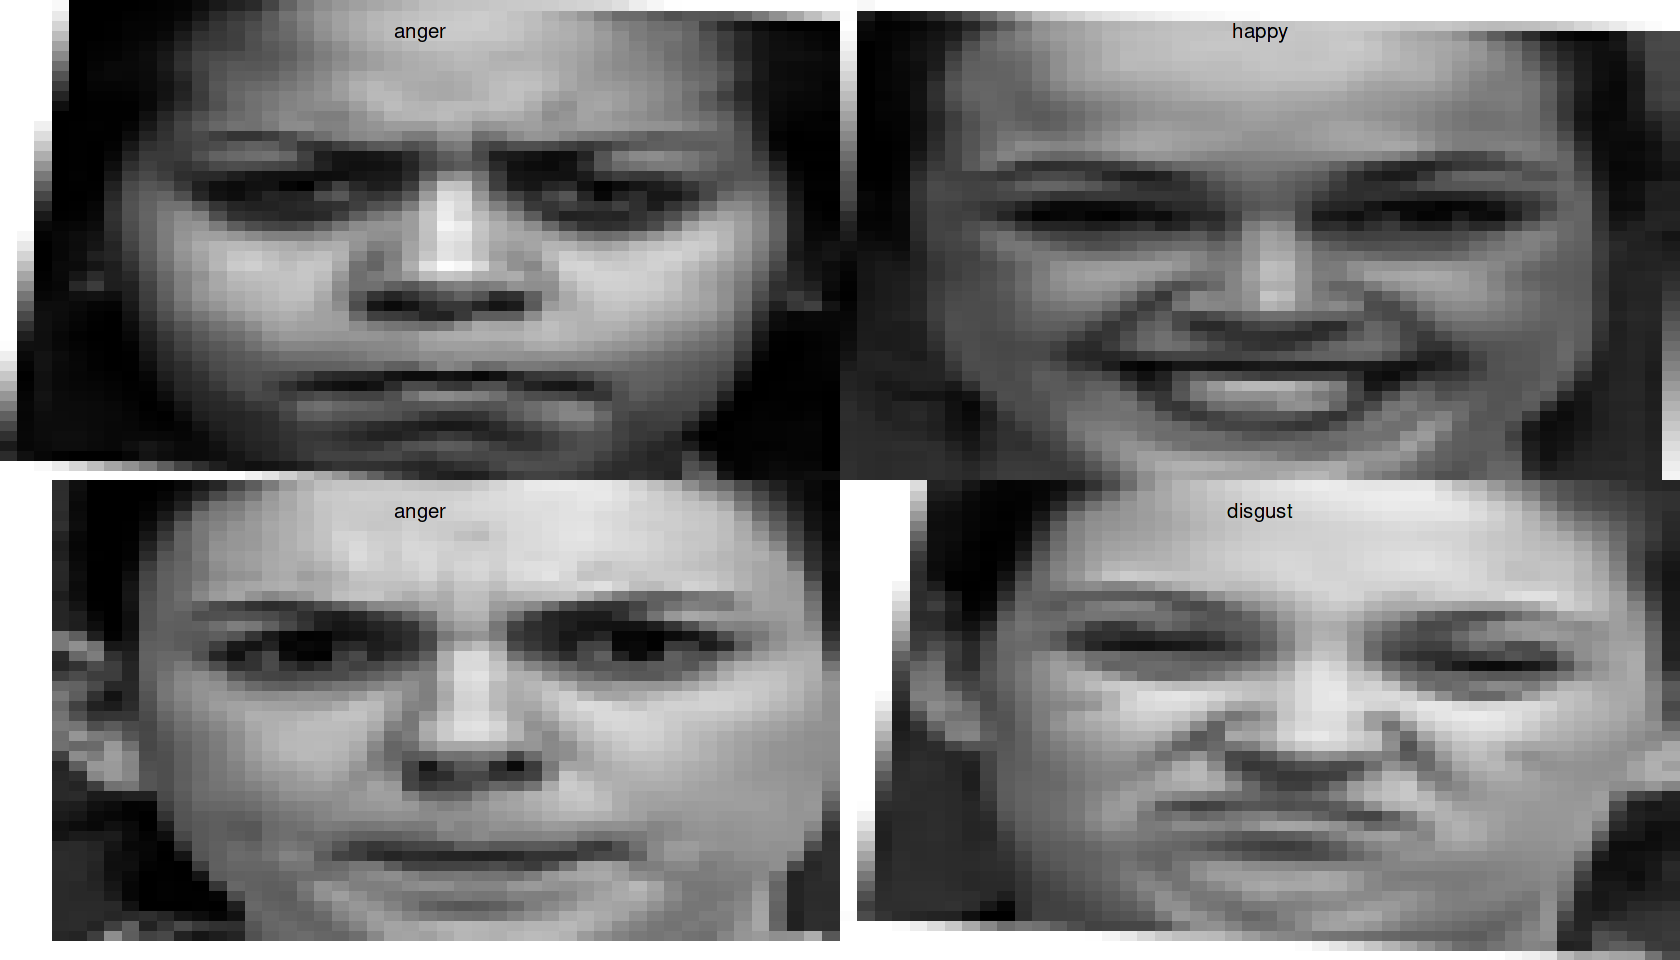

In [212]:
# Plot some of the pictures
layout(matrix(1:4, nrow = 2))

par(mar = c(2, 2, 2, 2))
as_image(train_X[41,])
mtext(train_y[41])

par(mar = c(2, 2, 2, 2))
as_image(test_X[41,])
mtext(test_y[41])

par(mar = c(2, 2, 2, 2))
as_image(train_X[499,])
mtext(train_y[499])

par(mar = c(2, 2, 2, 2))
as_image(test_X[499,])
mtext(test_y[499])

_Note: It looks like some of the picture labels are wrong. We could not figure out where we went wrong because we did not change the code we were given._

# 3. Feature Extraction

To classify the pictures we need to extract features from them. They need to be invariant to transformations like flipping and skewing to accomodate the wide variety in pictures and faces. To do so will not only use the "raw" pixels we extracted above, but also so-called "edges". Edges represent areas where the pixel values change abruptly. This gives an outline of the pictures based on significant changes in intensity, color, or texture of the image. 

First, we will create helper functions to extract basic statistical summaries and frey and slate features. Then we will apply them to the raw pixes, the raw edges, and the thresholded edges. In the end we will combine all those features in one dataframe and remove near zero variance and highly correlated features. 

## 3.1 Writing helper functions

To make the working process easier, we wrote a function that automatically extracts basic summary statistics like mean, variance and standard deviation and a function to extract so-called frey and slate features from the edges.

### 3.1.1 Entropy

In [213]:
entropy <- function(X, nbreaks = 30) {
    r <- range(X)
    x_binned <- findInterval(X, seq(r[1], r[2], length.out = nbreaks))
    h <- tabulate(x_binned, nbins = nbreaks) # fast histogram
    p <- h / sum(h)
    -sum(p[p > 0] * log(p[p > 0]))
}

### 3.1.2 Basic Statistics

In [214]:
stats <- function(input_df, suffix) {
    
  # Calculate mean, variance, standard deviation, ect. per row
  means <- rowMeans(input_df)
  variances <- apply(input_df, 1, var)
  std_dev <- apply(input_df, 1, sd)
  mins <- apply(input_df, 1, min)
  maxs <- apply(input_df, 1, max)
  medians <- apply(input_df, 1, median)
  entropies <- apply(input_df, 1, entropy)

  # Create a new dataframe with modified column names
  result_df <- data.frame(
    Mean = means,
    Variance = variances,
    StandardDeviation = std_dev,
    Minima = mins,
    Maxima = maxs,
    Medians = medians,
    Entropy = entropies
  )

  # Add the specified suffix to column names
  colnames(result_df) <- paste0(colnames(result_df), "_", suffix)

  return(result_df)
}

### 3.1.3 Frey and Slate Features

In [215]:
# Frey and Slate Features
frey_slate_features <- function(edge_matrix) {
  n <- ncol(edge_matrix)
  m <- nrow(edge_matrix)
  
  on_pixels <- which(edge_matrix == 1, arr.ind = TRUE)
  num_on_pixels <- nrow(on_pixels)
  
  if(num_on_pixels == 0) {
    # Handle cases where there are no "on" pixels
    return(rep(0, 13))
  }

  x.bar <- mean(on_pixels[,2])
  y.bar <- mean(on_pixels[,1])
  
  x2.bar <- mean((on_pixels[,2] - x.bar)^2)
  y2.bar <- mean((on_pixels[,1] - y.bar)^2)
  
  xybar <- mean((on_pixels[,2] - x.bar) * (on_pixels[,1] - y.bar))
  
  x2y.bar <- mean((on_pixels[,2] - x.bar)^2 * (on_pixels[,1] - y.bar))
  xy2.bar <- mean((on_pixels[,2] - x.bar) * (on_pixels[,1] - y.bar)^2)
  
  h_edges <- which(diff(edge_matrix) == 1, arr.ind = TRUE)
  v_edges <- which(diff(t(edge_matrix)) == 1, arr.ind = TRUE)
  
  x.ege <- nrow(h_edges) / n
  y.ege <- nrow(v_edges) / m
  
  xegvy <- sum(h_edges[,1]) / n
  yegvx <- sum(v_edges[,2]) / m
  
  return(c(x.bar, y.bar, x2.bar, y2.bar, xybar, x2y.bar, xy2.bar, x.ege, xegvy, y.ege, yegvx))
}

## 3.2 Raw Pixel Analysis

Before analyzing edges, we applied some basic summary statistics to the raw pixels and remove near-zero variance pixels.

### 3.2.1 Applying stats function

In [216]:
pixel_stats <- stats(X,"pixel")
head(pixel_stats, 3)

,Mean_pixel,Variance_pixel,StandardDeviation_pixel,Minima_pixel,Maxima_pixel,Medians_pixel,Entropy_pixel
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
anger/S010_004_00000018a.png,0.3215448,0.05780568,0.2404281,0,1,0.3058824,3.077057
anger/S010_004_00000018b.png,0.3731516,0.07912760,0.2812963,0,1,0.3470588,3.146437
anger/S010_004_00000018c.png,0.3998434,0.08583841,0.2929819,0,1,0.3725490,3.168979


### 3.2.2 Removing Near-Zero Variance Pixels



In [217]:
# Identifying columns to be removed
variance_threshold <- 0.045
variances <- apply(X, 2, var)

# Filter the columns based on the variance threshold
filtered_X <- X[, variances >= variance_threshold]

# Calculate the number of removed columns
num_removed_columns <- ncol(X) - ncol(filtered_X)

# Display the number of removed columns and the head of the original matrix
cat("Number of removed columns:", num_removed_columns, "\n")

# REMOVING COLUMNS FROM DATAFRAME
# Identify common columns
common_columns <- intersect(colnames(X), colnames(filtered_X))

# Subset X to keep only common columns
X_filtered <- X[, common_columns]
ncol(X_filtered) == ncol(filtered_X)

Number of removed columns: 605 


[1] TRUE

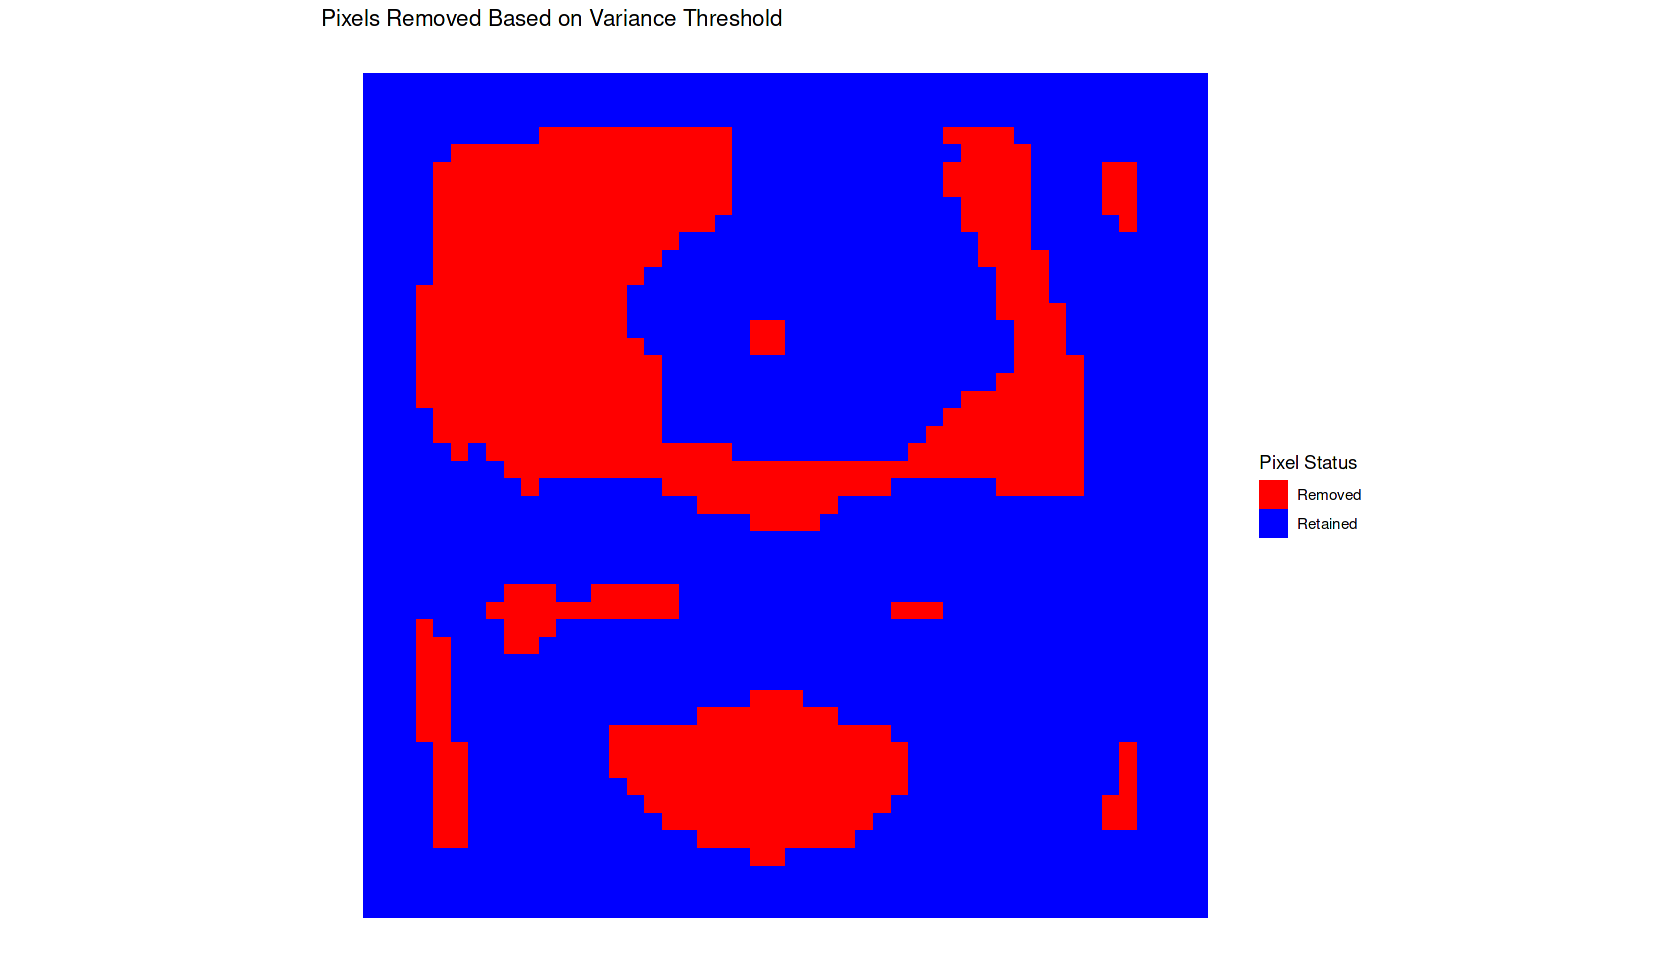

In [218]:
# Create a binary matrix of the same size as your image
pixel_retention_matrix <- matrix(1, nrow=48, ncol=48)

# Set the removed pixels to 0
removed_pixel_indices <- which(variances < variance_threshold)
pixel_retention_matrix[removed_pixel_indices] <- 0

# Plot the binary matrix
pixel_df <- data.frame(
  x = rep(1:48, each=48),
  y = rep(1:48, times=48),
  retained = as.vector(pixel_retention_matrix)
)

ggplot(pixel_df, aes(x=x, y=y, fill=factor(retained))) +
  geom_tile() +
  scale_fill_manual(values = c("red", "blue"), 
                    name = "Pixel Status",
                    breaks = c(0, 1),
                    labels = c("Removed", "Retained")) +
  coord_fixed(ratio = 1) +
  theme_void() +
  labs(title = "Pixels Removed Based on Variance Threshold")


## 3.3 Edge Analysis

### 3.3.1 Extracting Edges

In [219]:
# ------ Define the Edge Detection Functions ------

# Define the threshold
threshold <- 0.0625

# Function to perform edge detection
edge_detection <- function(image) {
  h_edge <- image[-1,] - image[-nrow(image),]
  v_edge <- image[,-1] - image[,-ncol(image)]
  d_edge <- h_edge[,-1] - h_edge[,-ncol(h_edge)]

  # Apply the threshold
  h_edgeT <- h_edge < threshold
  v_edgeT <- v_edge < threshold
  d_edgeT <- d_edge < threshold / 2

  # Return the results as a list
  return(list(horizontal = h_edge, vertical = v_edge, diagonal = d_edge, 
              horizontalThreshold = h_edgeT, verticalThreshold = v_edgeT, 
              diagonalThreshold = d_edgeT))
}

# Flatten and convert list of matrices from edge_detection into a numeric vector
flatten_edges <- function(edge_list) {
  # Convert each matrix in the list into a vector and concatenate them all into a single vector
  return(c(as.vector(edge_list$horizontal), 
           as.vector(edge_list$vertical),
           as.vector(edge_list$diagonal)))
}

flatten_edges_thresholded <- function(edge_list) {
  # Convert each thresholded matrix in the list to numeric, then into a vector, 
  # and concatenate them all into a single vector
  return(c(as.vector(as.numeric(edge_list$horizontalThreshold)), 
           as.vector(as.numeric(edge_list$verticalThreshold)),
           as.vector(as.numeric(edge_list$diagonalThreshold))))
}


# ------ Applying Edge Detection Functions ------

# Original edge features
edge_X <- lapply(1:nrow(X), function(i) {
  im <- matrix(X[i,], 48)
  edges <- edge_detection(im)
  return(flatten_edges(edges))
})

# Thresholded edge features
edge_X_thresholded <- lapply(1:nrow(X), function(i) {
  im <- matrix(X[i,], 48)
  edges <- edge_detection(im)
  return(flatten_edges_thresholded(edges))
})


# ------ Combine Extracted Features with Raw Pixel Values ------

# With thresholded edges
combinedX_rawPixels <- cbind(X, do.call(rbind, edge_X))
combinedX_rawPixels_thresholded <- cbind(X, do.call(rbind, edge_X_thresholded))


# ------ Store Raw and Thresholded edges in dataframes ------

rawEdges <- combinedX_rawPixels[,-(1:2304)]
thresholdedEdges <- combinedX_rawPixels_thresholded[,-(1:2304)]

# Create new column names "e1", "e2", ..., "en"
mycolnamesR <- paste0("eR", 1:ncol(rawEdges))
mycolnamesT <- paste0("eR", 1:ncol(rawEdges))

# Set the column names of 'filtered_X' to the new names
colnames(rawEdges) <- mycolnamesR
colnames(thresholdedEdges) <- mycolnamesT

### 3.3.2 Extracting Edge Features

In [220]:
# ------ Extract Statistical Features ------

edge_stats <- stats(combinedX_rawPixels, "edge_X")
edge_stats_thresholded <- stats(combinedX_rawPixels_thresholded, "edge_X_thresholded")

#### Visualizing Edges

In [ ]:
# Function to visualize the original, thresholded, and edge images
visualize_edge_comparison <- function(original_matrix, edge_features, edge_features_thresholded, index) {
  # Extract original image and reshape it to a 48x48 matrix
  original_image <- matrix(original_matrix[index,], 48)
  
  # Extract and reshape original edge features to their respective image shapes
  h_edge_image <- matrix(edge_features[[index]][1:(48*47)], 48, 47, byrow = TRUE)
  v_edge_image <- matrix(edge_features[[index]][(48*47 + 1):(48*47 + 48*47)], 48, 47, byrow = TRUE)
  d_edge_image <- matrix(edge_features[[index]][(2*48*47 + 1):(2*48*47 + 47*47)], 47, 47, byrow = TRUE)
  
  # Extract and reshape thresholded edge features to their respective image shapes
  h_edge_thresh_image <- matrix(edge_features_thresholded[[index]][1:(48*47)], 48, 47, byrow = TRUE)
  v_edge_thresh_image <- matrix(edge_features_thresholded[[index]][(48*47 + 1):(48*47 + 48*47)], 48, 47, byrow = TRUE)
  d_edge_thresh_image <- matrix(edge_features_thresholded[[index]][(2*48*47 + 1):(2*48*47 + 47*47)], 47, 47, byrow = TRUE)
  
  # Define a helper function for the ggplot raster
  plot_edge <- function(image_data, title) {
    ggplot() +
      geom_raster(data = NULL, aes(x = x, y = y, fill = value), interpolate = TRUE) +
      scale_fill_gradient(low = "black", high = "white") +
      ggtitle(title) +
      theme_void() + theme(legend.position = "none") +
      coord_fixed(ratio = 1)
  }
  
  p1 <- plot_edge(as.vector(t(original_image)), "Original Image")
  p1$data <- expand.grid(x = 1:48, y = 1:48)
  p1$data$value <- as.vector(t(original_image))
  
  p2 <- plot_edge(as.vector(t(h_edge_image)), "Horizontal Edges")
  p2$data <- expand.grid(x = 1:48, y = 1:47)
  p2$data$value <- as.vector(t(h_edge_image))
  
  p3 <- plot_edge(as.vector(t(v_edge_image)), "Vertical Edges")
  p3$data <- expand.grid(x = 1:47, y = 1:48)
  p3$data$value <- as.vector(t(v_edge_image))
  
  p4 <- plot_edge(as.vector(t(d_edge_image)), "Diagonal Edges")
  p4$data <- expand.grid(x = 1:47, y = 1:47)
  p4$data$value <- as.vector(t(d_edge_image))

  p5 <- plot_edge(as.vector(t(h_edge_thresh_image)), "Thresholded Horizontal Edges")
  p5$data <- expand.grid(x = 1:48, y = 1:47)
  p5$data$value <- as.vector(t(h_edge_thresh_image))

  p6 <- plot_edge(as.vector(t(v_edge_thresh_image)), "Thresholded Vertical Edges")
  p6$data <- expand.grid(x = 1:47, y = 1:48)
  p6$data$value <- as.vector(t(v_edge_thresh_image))

  p7 <- plot_edge(as.vector(t(d_edge_thresh_image)), "Thresholded Diagonal Edges")
  p7$data <- expand.grid(x = 1:47, y = 1:47)
  p7$data$value <- as.vector(t(d_edge_thresh_image))

  # Arrange the plots in a grid
  grid.arrange(p1, p2, p3, p4, p5, p6, p7)
  }

# Use the function to visualize the 1st image, its edge features, and its thresholded edge features
visualize_edge_comparison(X, edge_X, edge_X_thresholded, 1)

In [222]:
# ------ Extract Frey Slate Features ------

freyslate_features_thresholded <- t(sapply(1:nrow(X), function(i) {
  im <- matrix(X[i,], 48)
  edges <- edge_detection(im)
  return(frey_slate_features(edges$horizontalThreshold))
}))

## 3.5 Final Dataframe

### 3.5.1 Combining Dataframes

The last thing to do was to combine all previously created dataframes. We included the

* raw, non-zero pixels
* summary statistics of raw, non-zero pixels
* raw edges
* summary statistics of raw edges
* summary statistics of thresholded edges
* frey and slate features of thresholded edges

_Note._ We decided to no use the thresholded edges in the end, but only their summary statistics and frey and slate features. We realized that they did not add much to predictive accuracy, but increased running time by a lot.

In [ ]:
finalX <- cbind(X_filtered, # non-zero variance pixels
                pixel_stats, # summary statistic - pixels
                rawEdges, # raw edges
                edge_stats, # summary statistics - edges
                edge_stats_thresholded, # summary statistics - thresholded edges
                freyslate_features_thresholded # frey and slate features - thresholded edges
               )


### 3.5.2 Removing reduntant features


Next, remove redundant variables. We remove variables which (have/are):

* Near-zero variance
* Highly correlated variables
* Multi-collinearity

Redunant variables can be removed from the training dataset because they do not contribute meaningful information to the analysis and do not help discriminate between observations. By removing such variables, we simplify our model, which can lead to more interpretable results and understandable models. 

Moreover, having too many features or variables, especially those with low or no variance, can lead to overfitting. By removing uninformative features, we reduce the risk of overfitting and improve the model's generalization to new data. 

Finally, redunant variables increase the computational cost of modeling and analysis without providing any real benefit. Removing them can speed up the processing time and reduce memory usage. onal cost of modeling and analysis without providing any real benefit. Removing them can speed up the processing time and reduce memory usage.


#### Removing Near-Zero variance features

Variables with near-zero variation are variables with mostly one and the same value. Variables with no or very little variation can be removed from the training dataset because they are essentially constant and do not help discriminate between observations.Variables with near-zero variation are variables with mostly one and the same value. Variables with no or very little variation can be removed from the training dataset because they are essentially constant and do not help discriminate between observations.

In [ ]:
variance_threshold <- 0.01 # TODO: THIS THRESHOLD IS ARBITRARY, 
variances <- apply(finalX, 2, var)

# Filter the columns based on the variance threshold
finalX_filtered <- finalX[, variances >= variance_threshold]

# Calculate the number of removed columns
num_removed_columns <- ncol(finalX) - ncol(finalX_filtered)

# Display the number of removed columns and the head of the original matrix
cat("Number of removed columns:", num_removed_columns, "\n") 
cat("Number of remaining columns:", ncol(finalX) - num_removed_columns)

Number of removed columns: 5246 
Number of remaining columns: 3206

#### Highly correlated features

High correlation between features indicate they provide same or very similar information. This leads to instability of coefficient estimates (collinearity or inestimability in the worst cases). In order to correct for these highly correlated variables we remove features that have a correlation above 0.98 for the reasons desribed above. We used such a large correlation threshold because of spatial correlations in the data, this is, the pixels represent an image and it is very likely that the pixel intensity of one space will be predictive of the neighbor's pixel intensity. A lower correlation threshold would mean a loss of data and important predictors.

In [ ]:
high_cor <- caret::findCorrelation(cor(finalX_filtered[,-ncol(finalX_filtered)]))
final_X <- finalX_filtered[,high_cor]

cat("Number of removed columns:", ncol(final_X) - length(high_cor), "\n") 
cat("Number of remaining columns:", length(high_cor))

Number of removed columns: 0 
Number of remaining columns: 2402

### 3.5.4 Freeing up RAM

As fitting the models is very computationally heavy process, we deleted all dataframes from the working directory except for the two final ones.

In [ ]:
# freeing up some RAM
# List the names of the objects you want to keep
objects_to_keep <- c("final_X", "XmodelsNormalized", "train_y", "test_y", "train_val", "X_test", "y", "test_indices")

# List all objects in the current environment
all_objects <- ls()

# Remove all objects except the ones in objects_to_keep
objects_to_remove <- setdiff(all_objects, objects_to_keep)
rm(list = objects_to_remove)

### 3.5.5 Splitting Data in Test and Train


In [244]:
dim(final_X)
# Define training & validation set
train_X = final_X[train_val, ]
test_X = final_X[-c(train_val, test_indices), ]

XmodelsNormalized <- scale(final_X)
train_X_normalized = XmodelsNormalized[train_val, ]
test_X_normalized = XmodelsNormalized[-c(train_val, test_indices), ]

[1] 3618 2402

# 4. Model Fitting


## 4.1 Classification tree

We consider classification trees and random forests. Random forests are probably the least susceptible to overtraining and is considered one of the best "off the shelf" machine learning algorithms in the sense that they require little expertise in application, and easily perform well without tuning. Classification trees have the benefit of discovering non-linear patterns in the data, which may aid in the prediction of emotional expressions, without oversimplifying the fit.

We fit a classification tree, using the pixel based approach. 

In [ ]:
# Speed up tuning by using all 4 CPU cores
doMC::registerDoMC(cores = 4) 

# Ensure repeatability
set.seed(2023)

# Tuning parameter: 5-fold cross-validation to tune the complexity parameter
trCntrl = trainControl('cv', 5, allowParallel = TRUE)
tt <- Sys.time()

# Fit a CART
fit_tree = train(x=train_X_normalized, y=train_y, method='rpart', trControl = trCntrl, tuneGrid = data.frame(cp=.02))
fit_tree

(dur <- Sys.time() - tt)

CART 

2032 samples
2402 predictors
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1625, 1626, 1626, 1625, 1626 
Resampling results:

  Accuracy   Kappa    
  0.5127764  0.3103435

Tuning parameter 'cp' was held constant at a value of 0.02

Time difference of 16.81662 secs

n= 2032 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 2032 1336 happy (0.224409449 0.293307087 0.342519685 0.139763780)  
   2) p754>=-0.587841 1489  994 disgust (0.250503694 0.332437878 0.255876427 0.161182001)  
     4) p1532< 0.628286 972  613 disgust (0.301440329 0.369341564 0.122427984 0.206790123)  
       8) p1213>=-0.3925891 710  401 disgust (0.276056338 0.435211268 0.146478873 0.142253521)  
        16) p1614>=0.9148194 213  118 anger (0.446009390 0.225352113 0.103286385 0.225352113) *
        17) p1614< 0.9148194 497  236 disgust (0.203219316 0.525150905 0.164989940 0.106639839) *
       9) p1213< -0.3925891 262  162 sad (0.370229008 0.190839695 0.057251908 0.381679389)  
        18) p1670< -0.1331999 178   92 anger (0.483146067 0.179775281 0.067415730 0.269662921) *
        19) p1670>=-0.1331999 84   32 sad (0.130952381 0.214285714 0.035714286 0.619047619) *
     5) p1532>=0.628286 517  255 happy (0.154738878 0.263056093 0.506769826 0.0754352

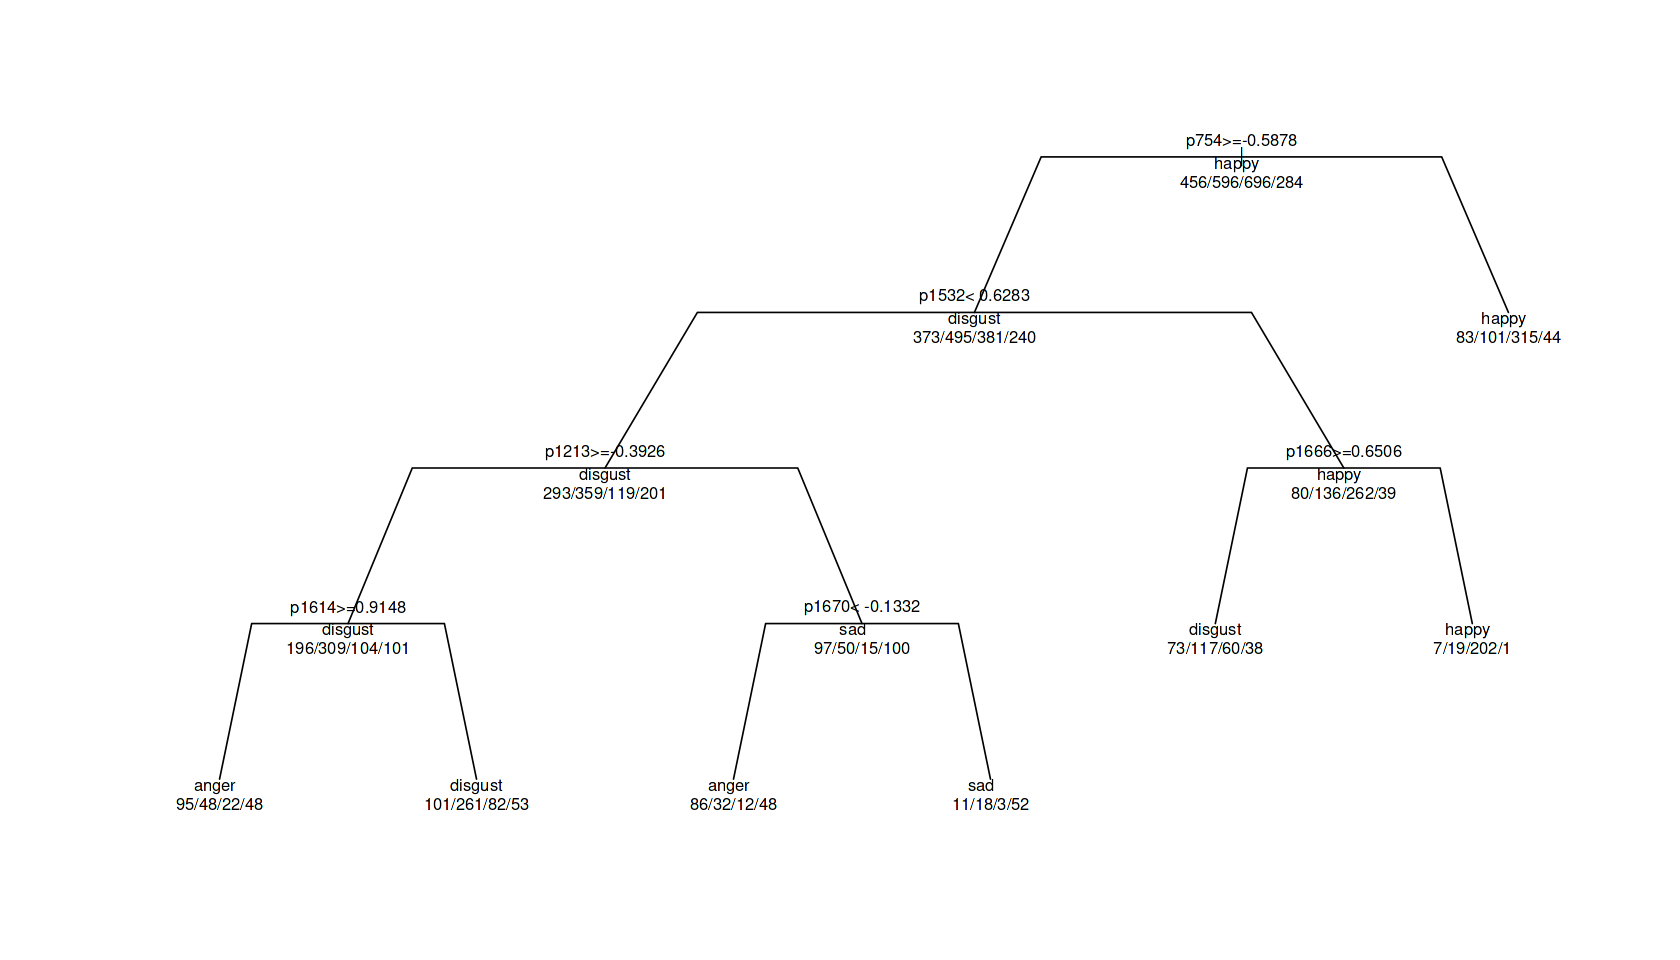

In [ ]:
## Graphical visualization of the decision tree
options(repr.plot.width=14, repr.plot.height=8)
plot(fit_tree$final, compress=TRUE, uniform=TRUE, margin=0.05, branch=.75); 
text(fit_tree$final, cex=0.8, all=TRUE, use.n=TRUE)

## Textual visualization of the decision tree
fit_tree$finalModel

The cross validated accuracy for classification tree estimate is around 56%.

In [ ]:
# Performance evaluation classification tree on the normalized training set
pred_tree = predict(fit_tree,
                    train_X_normalized, 
                    type='raw')

# Assessing Accuracy in Confusion-Matrix
confusion_tree <- caret::confusionMatrix(pred_tree, factor(train_y))

# Overall accuracy
accuracy_tree <- confusion_tree$overall['Accuracy']


# Print accuracies
print(confusion_tree$table)
print(confusion_tree$byClass[,1:2])
print(paste("Overall Accuracy: ", round(accuracy_tree, 3)))

          Reference
Prediction anger disgust happy sad
   anger     181      80    34  96
   disgust   174     378   142  91
   happy      90     120   517  45
   sad        11      18     3  52
               Sensitivity Specificity
Class: anger     0.3969298   0.8667513
Class: disgust   0.6342282   0.7165738
Class: happy     0.7428161   0.8091317
Class: sad       0.1830986   0.9816934
[1] "Overall Accuracy:  0.555"


In [ ]:
#### Alternative 
# Performance evaluation prediction tree 
pred_tree = predict(fit_tree, 
                     as.matrix(test_X_normalized),  
                     type = 'raw') %>% 
as.factor()

# Assessing Accuracy in Confusion-Matrix
confusion_tree <- caret::confusionMatrix(pred_tree,factor(test_y))

# Overall accuracy
accuracy_tree <- confusion_tree$overall['Accuracy']

# Print accuracies
print(confusion_tree$table)
print(confusion_tree$byClass[,1:2])
print(paste("Overall Accuracy: ", round(accuracy_tree, 3)))

          Reference
Prediction anger disgust happy sad
   anger      44      28    10  26
   disgust    42      83    35  16
   happy      28      30   128  14
   sad         0       7     1  14
               Sensitivity Specificity
Class: anger     0.3859649   0.8367347
Class: disgust   0.5608108   0.7402235
Class: happy     0.7356322   0.7831325
Class: sad       0.2000000   0.9816514
[1] "Overall Accuracy:  0.532"


In [243]:
print(length(pred_tree))
print(length(test_y))
print(length(train_y))
print(length(train_X))
print(dim(test_X_normalized))

[1] 506
[1] 506
[1] 2032
[1] 2402
[1]  506 2402


## 4.2 Ridge (Multinomial Regression with Ridge)

Since we are faced with a classification problem a natural choice is using a multinomial distribution to predict each observation to one of the four classes. Thus, we fitted a multinomial regression model. To prevent overfitting and decrease the number of predictors we apply regularisation. First we used ridge regularisation which shrinks coefficient estimates that do not contribute much to the prediction near zero. This penalty is not applied to the intercept (James et al., 2021).

In [ ]:
# Speed up tuning by using all 4 CPU cores
doMC::registerDoMC(cores = 4) 

# Ensure repeatability
set.seed(2023)

# Performing ridge regression
fit_ridge <- glmnet::cv.glmnet(as.matrix(train_X_normalized),
                               factor(train_y),
                               family = "multinomial",
                               nfolds = 5,
                               alpha = 0,
                               type.measure = "class",
                               standardize = TRUE)

In [ ]:
# Performance evaluation CV Ridge
pred_ridge = predict(fit_ridge, 
                     as.matrix(test_X_normalized), 
                     s = 'lambda.min', 
                     type = 'class') %>% 
as.factor()

# Assessing Accuracy in Confusion-Matrix
confusion_ridge <- caret::confusionMatrix(pred_ridge,factor(test_y))

# Overall accuracy
accuracy_ridge <- confusion_ridge$overall['Accuracy']

# Print accuracies
print(confusion_ridge$table)
print(confusion_ridge$byClass[,1:2])
print(paste("Overall Accuracy: ", round(accuracy_ridge, 3)))

          Reference
Prediction anger disgust happy sad
   anger      70      11     1  20
   disgust    28     118     2  23
   happy       6      18   171   0
   sad        10       1     0  27
               Sensitivity Specificity
Class: anger     0.6140351   0.9183673
Class: disgust   0.7972973   0.8519553
Class: happy     0.9827586   0.9277108
Class: sad       0.3857143   0.9747706
[1] "Overall Accuracy:  0.763"


The accuracy estimate for ridge regression is around 79%.

## 4.3 Lasso (Multinomial Regression with Lasso)

Next, we fitted a multinomial regression model with lasso regularisation. Like ridge regularisation, the lasso forces a penalty on the coefficent estimates that do not contribute much to the prediction of the model so that they are drawn towards zero. But in contrast to ridge, the lasso shrinks some of the coefficient estimates, those that contribute the least to the prediction of the model, entirely to zero (James et al., 2021). This results in automated feature selection.

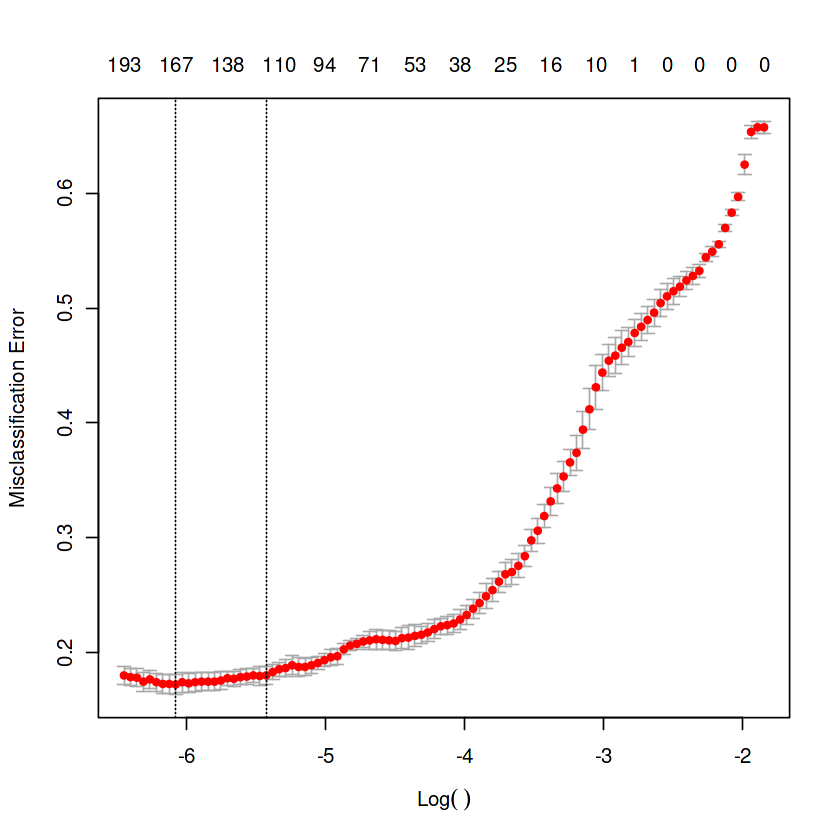

In [ ]:
# Speed up tuning by using all 4 CPU cores
doMC::registerDoMC(cores = 4) 

# Ensure repeatability
set.seed(2023)

# Performing lasso regression
fit_lasso <- glmnet::cv.glmnet(as.matrix(train_X_normalized), 
                       factor(train_y), 
                       family = "multinomial",
                       nfolds = 5,
                       alpha = 1, 
                       type.measure = "class",
                       standardize = TRUE)


options(repr.plot.width = 7, repr.plot.height = 7)

# Plot misclassicication rate over the log of Lambda 
plot(fit_lasso)

In [ ]:
# Performance evaluation CV Lasso
pred_lasso = predict(fit_lasso, 
                     as.matrix(test_X_normalized), 
                     s = 'lambda.min', 
                     type = 'class') %>% 
as.factor()

# Assessing Accuracy in Confusion-Matrix
confusion_lasso = caret::confusionMatrix(pred_lasso,factor(test_y))

# Overall accuracy
accuracy_lasso <- confusion_lasso$overall['Accuracy']

# Print accuracies
print(confusion_lasso$table)
print(confusion_lasso$byClass[,1:2])
print(paste("Overall Accuracy: ", round(accuracy_lasso, 3)))

          Reference
Prediction anger disgust happy sad
   anger      84      12     0  16
   disgust    15     125     7  14
   happy       2       7   167   0
   sad        13       4     0  40
               Sensitivity Specificity
Class: anger     0.7368421   0.9285714
Class: disgust   0.8445946   0.8994413
Class: happy     0.9597701   0.9728916
Class: sad       0.5714286   0.9610092
[1] "Overall Accuracy:  0.822"


The accuracy estimate for a multinomial regression model with Lasso is around 82%.

## 4.4 Linear Discriminant Analysis (LDA)

A Linear Discriminant Analysis (LDA) was executed in order to fit a model to predict emotional facial expressions (more than two classes) based on the selected pixels. LDA involves separating the data space into different regions representing the different classes. It linearly transformes the original feature space into a new space, such that the classes become as separable as possible. This transformation is achieved by finding a set of linear discriminant functions. Those discriminant functions are linear combinations of the original features which maximize the between-class variance while minimizing the within-class variance.

The assumption that the computed features (histogram features, spatial frequency magnitudes... etc) are normally distributed within each class, is most likely met based on the central limit theorem. The emotional facial expressions in different classes most likely share a common covariance matrix because the facial emotional expression data origins from the same individuals across classes. Further, the features are expected to have equal covariances in all classes because all pictures will have an oval shape  depicting the face. Nevertheless, there will be class-specific variance to make predictions. For example, a disguisted emotional facial expression might show closed eyes whereas a happy emotional facial expression might show teeth. This would indicate a class specific mean vector. 

However, when simply using all features, there are more features than observations, thus, it would be impossible to fit the LDA. Therefore, we pre-process the features with a Principal Component Analysis (PCA) to limit the dimensions.

In [ ]:
# Speed up tuning by using all 4 CPU cores
doMC::registerDoMC(cores = 4) 

# Ensure repeatability
set.seed(2023)

# tuning parameter
trcntr <- trainControl('cv', 
                       number = 2,
                       p = 0.8)

# fit LDA model
fit_lda <- train(train_y ~ ., 
                data = cbind(train_X, train_y), 
                method = "lda", 
                trControl = trcntr, 
                preProcess="pca")

In [ ]:
# predict the validation set
pred_lda <- predict(fit_lda, 
                    test_X_normalized, 
                    type='raw') 

# Assessing Accuracy in Confusion-Matrix
confusion_lda = caret::confusionMatrix(pred_lda,factor(test_y))

# Overall accuracy
accuracy_lda <- confusion_lda$overall['Accuracy']

# Print accuracies
print(confusion_lda$table)
print(confusion_lda$byClass[,1:2])
print(paste("Overall Accuracy: ", round(accuracy_lda, 3)))

          Reference
Prediction anger disgust happy sad
   anger      67      28     3   6
   disgust     6      74    12   1
   happy       0       8   152   0
   sad        41      38     7  63
               Sensitivity Specificity
Class: anger     0.5877193   0.9056122
Class: disgust   0.5000000   0.9469274
Class: happy     0.8735632   0.9759036
Class: sad       0.9000000   0.8027523
[1] "Overall Accuracy:  0.704"


The accuracy estimate for a linear discriminant analysis (LDA) model is around XX%.


Note: We also tried to fit a Quadratic Discriminant Analysis model (QDA). This is a variant of the LDA model. LDA assumes that the covariance matrixes are the same for every class whereas QDA estimates a covariance matrix for each class (James et al., 2022). While LDA results in linear decision boundaries, QDA's decision boundaries can be non-linear. Because the covariance matrixes differ between classes in QDA, more parameters need to be estimated. Given that we have a vast amount of features we tried again to reduce the dimensions with a PCA in order to fit a QDA. However, an attempt to run a QDA model failed.

## 4.5 K-Nearest Neighbors (K-NN)

K Nearest Neighbors (K-NN) is a non-parametric approach for classification problems. K-NN is a method where every point of interest is classified based on the class of similar other observations. The K represents the number of other observations a point is compared with. In order to make a prediction for an observation X = x, the training observations that are closest to x are identified. Then X is assigned to the class to which the majority of these observations belong (James et al., 2021). Therefore, K-NN is a simple and effective algorithm for emotional facial expression recognition, particularly since the dataset is not very large. We applied the K-NN algorithm to the full dataset. The K-NN algorithm was applied with the resampling method 10-fold cross-validation.

In [ ]:
# Speed up tuning by using all 4 CPU cores
doMC::registerDoMC(cores = 4) 

# Ensure repeatability
set.seed(2023)

# tuning parameter
trCntrl = trainControl('cv', number = 5, allowParallel = TRUE) 

# fit K-NN classifier
fit_knn = caret::train(y = train_y, 
                       x = train_X_normalized,
                       method = 'knn',
                       trControl = trCntrl)

In [ ]:
# Performance evaluation K-NN
knn_pred <- predict(fit_knn, 
                    as.matrix(test_X_normalized), 
                    type='raw') 

# Assessing Accuracy in Confusion-Matrix
confusion_knn <- caret::confusionMatrix(knn_pred, factor(test_y))

# Overall accuracy
accuracy_knn <- confusion_knn$overall['Accuracy']

# Print accuracies
print(confusion_knn$table)
print(confusion_knn$byClass[,1:2])
print(paste("Overall Accuracy: ", round(accuracy_knn, 3)))

          Reference
Prediction anger disgust happy sad
   anger      51      24    13  16
   disgust    33      80    28  18
   happy      10      37   121  14
   sad        20       7    12  22
               Sensitivity Specificity
Class: anger     0.4473684   0.8647959
Class: disgust   0.5405405   0.7793296
Class: happy     0.6954023   0.8162651
Class: sad       0.3142857   0.9105505
[1] "Overall Accuracy:  0.542"


The accuracy estimate for the K-NN classifier is around XX%.

## 4.6 Support Vector Machine (SVMs)

Support Vector Machines (SVMs) map features non-linearly into high dimensions (Mehta et al, 2019). SVMs are no probability models but make use of a hyperplane that classifies observations. Thus, SVMs are well generalizable to new data (James et al., 2021).
Even though all models above performed well, we have reason to assume a complex underlying mechanism of the data. Emotion, underlying the facial expressions in the image data, is a very complex human mechanism that we would not want to oversimplify. Thus, we fit a model that reflects this complexity.

In [ ]:
# Speed up tuning by using all 4 CPU cores
doMC::registerDoMC(cores = 4) 

# Ensure repeatability
set.seed(2023)

# fit linear svm
# Note: For fitting this model we use the NOT normalized data because data preprocessing is built in this function
fit_svm <- train(x = train_X, 
                 y = train_y, 
                 method = "svmRadial", 
                 trControl = trCntrl, 
                 preProcess = c("center","scale"), 
                 tuneLength = 10)

In [ ]:
# Calculate predictions
pred_svm <- predict(fit_svm, test_X)

# Assessing Accuracy in Confusion-Matrix
confusion_svm = caret::confusionMatrix(pred_svm,factor(test_y))

# Overall accuracy
accuracy_svm <- confusion_svm$overall['Accuracy']

# Print accuracies
print(confusion_svm$table)
print(confusion_svm$byClass[,1:2])
print(paste("Overall Accuracy: ", round(accuracy_svm, 3)))

ERROR: Error in table(data, reference, dnn = dnn, ...): all arguments must have the same length


The accuracy estimate for linear SVMs is around X%.

Furthermore, we use a radial SVM because of the aforementioned assumption of classes being not linearly separable.

In [ ]:
# Speed up tuning by using all 4 CPU cores
doMC::registerDoMC(cores = 4) 

# Ensure repeatability
set.seed(2023)

# e1071

# fit radial svm
tune_svm <- e1071::svm(x = train_X_normalized,
                       y = factor(train_y),
                       kernel = 'radial',
                       cost = 1,
                       scale = TRUE)

In [ ]:
# Calculate predictions
pred_e1071 <- predict(tune_svm, test_X_normalized)

# Assessing Accuracy in Confusion-Matrix
confusion_e1017 = caret::confusionMatrix(pred_e1071,factor(test_y))

# Overall accuracy
accuracy_e1017 <- confusion_e1017$overall['Accuracy']

# Print them
print(confusion_e1017$table)
print(confusion_e1017$byClass[,1:2])
print(paste("Overall Accuracy: ", round(accuracy_e1017, 3)))

The accuracy estimate for radial SVMs is around X%.

# 5. Model Comparison

The last step was choosing the best out of the five models we fitted. <br>

## 5.1 Bias-Variance Trade-off
A general thing to consider during model selection between models with varying levels of flexibility is the bias-variance trade-off. The more flexible a model is, the less biased it is, but the more variance it has and vice versa. More biased models make stronger assumptions about the underlying data distribution. Because of this, they might fit the (training) data less well than less biased models if the assumed underlying distribution is incorrect. Models with high variance, often have the opposite problem: they might fit the (training) data very well but predict future cases less well because of overfitting.

As mentioned above, the different modelling algorithms we used are associated with different levels of flexibility. In contrast to previous competitions, the goal of this competition is to achieve a good prediction accuracy, instead of the correct classification of unknown test data. Therefore we do not see from using also more flexible models. 

## 5.2 Prediction Accuracy

Prediction Accuracy refers to the proportion of correctly classified cases. Results showed that there is a "clear winnder", a "clear looser" and three medium models. The classification tree model performed a lot worse than all other models with an accuracy of 0.65. The support vector model performed the best with an accuracy of 0.95. 

In [ ]:
FitMeasures <- data.frame(Model = c("Classification Tree", "Ridge", "Lasso", "LDA", "K-NN", "Support Vector Machine", "Tuned Support Vector Machine"), 
                          Accuracy = c(accuracy_tree, accuracy_ridge, accuracy_lasso, accuracy_lda, accuracy_knn, accuracy_svm, accuracy_e1017))

# Create the ggplot bar plot
ggplot(FitMeasures, aes(x = Accuracy, y = Model)) +
  geom_bar(stat = "identity", fill = ifelse(FitMeasures$Accuracy == max(FitMeasures$Accuracy), "blue", "gray")) +
  geom_text(aes(label = round(Accuracy, 3)), hjust = -0.1) +
  labs(title = "Test Set Accuracy", x = "Accuracy") +
  xlim(0, 1.1) +
  theme_minimal() +
  coord_flip()

## 5.4 Cohen's Kappa

Cohen's Kappa is a measure of reliability of a model. The higher Kappa, the better the model. The pattern of Kappa values of the models is the same as for the model accuracies: The classification tree model performed very bad; lasso, ridge and tuned support vector medium, and support vector very well. So again, the support vector model is to be preferred.

In [ ]:
FitMeasures <- FitMeasures %>%
        mutate(Kappa = c(confusion_tree$overall[["Kappa"]], confusion_ridge$overall[["Kappa"]], confusion_lasso$overall[["Kappa"]],
                         confusion_lda$overall[["Kappa"]], confusion_knn$overall[["Kappa"]], confusion_svm$overall[["Kappa"]],
                         confusion_e1017$overall[["Kappa"]]))


# Create the ggplot bar plot
ggplot(FitMeasures, aes(x = Kappa, y = Model)) +
  geom_bar(stat = "identity", fill = ifelse(FitMeasures$Kappa == max(FitMeasures$Kappa), "blue", "gray")) +
  geom_text(aes(label = round(Kappa, 3)), hjust = -0.1) +
  labs(title = "Test Set Kappa", x = "Kappa") +
  xlim(0, 1.1) +
  theme_minimal() +
  coord_flip()


## 5.3 Sensitivity

Sensitvitiy refers to the proportion of true positive cases among all actual positives, indicating how well a model detects true cases and avoids false negatives. We observed the exact same pattern as with the other fit measures and again decided on the support vector model. 

In [ ]:
FitMeasures <- FitMeasures %>%
                    mutate(Sensitivity = c(mean(confusion_tree$byClass[,"Sensitivity"]), mean(confusion_ridge$byClass[,"Sensitivity"]), 
                                           mean(confusion_lasso$byClass[,"Sensitivity"]), mean(confusion_lda$byClass[,"Sensitivity"]), 
                                           mean(confusion_knn$byClass[,"Sensitivity"]), mean(confusion_svm$byClass[, "Sensitivity"]), 
                                           mean(confusion_e1017$byClass[, "Sensitivity"])))


# Create the ggplot bar plot
ggplot(FitMeasures, aes(x = Sensitivity, y = Model)) +
  geom_bar(stat = "identity", fill = ifelse(FitMeasures$Sensitivity == max(FitMeasures$Sensitivity), "blue", "gray")) +
  geom_text(aes(label = round(Sensitivity, 3)), hjust = -0.1) +
  labs(title = "Test Set Sensitivity", x = "Sensitivity") +
  xlim(0, 1.1) +
  theme_minimal() +
  coord_flip()

## 5.4 Specificity

Specificity refers to the proportion of true negative cases among all actual negatives, indicating how well a model avoids "false alarms". Interestingly, there are no huge differences in specificity between the models. The model that again had a slight advantage over all other models was the support vector model.

In [ ]:
FitMeasures <- FitMeasures %>%
                    mutate(Specificity = c(mean(confusion_tree$byClass[,"Specificity"]), mean(confusion_ridge$byClass[,"Specificity"]), 
                                           mean(confusion_lasso$byClass[,"Specificity"]), mean(confusion_lda$byClass[,"Specificity"]), 
                                           mean(confusion_knn$byClass[,"Specificity"]), mean(confusion_svm$byClass[, "Specificity"]), 
                                           mean(confusion_e1017$byClass[, "Specificity"])))


# Create the ggplot bar plot
ggplot(FitMeasures, aes(x = Specificity, y = Model)) +
  geom_bar(stat = "identity", fill = ifelse(FitMeasures$Specificity == max(FitMeasures$Specificity), "blue", "gray")) +
  geom_text(aes(label = round(Specificity, 3)), hjust = -0.1) +
  labs(title = "Test Set Specificity", x = "Specificity") +
  xlim(0, 1.1) +
  theme_minimal() +
  coord_flip()

## 5.5. Final Model Choice

Taking the bias-variance tradeoff, accuracy, sensitivity and specificity into account, we decided on the Support Vector Model as our final model. <br>

# 6. Submission

## 6.1 Refit Support Vector Model on all data

# discrepancy between final_X and X_test must be fixed before final predictions

In [245]:
# To extract the test data from the combined matrix using the saved indices (for demonstration)
extracted_X_train <- final_X[-test_indices, ]
dim(extracted_X_train)
X_test <- final_X[test_indices, ]

# refit svm on all observations
final_fit_svm <- train(x = extracted_X_train, 
                 y = y, 
                 method = "svmRadial", 
                 trControl = trCntrl, 
                 preProcess = c("center","scale"), 
                 tuneLength = 10)

[1] 2538 2402

The statistics of the new dataset (included the edges) are not computed succesfully.

## 6.2 Create Submission

In [246]:
## Make predictions
pred_svm = predict(final_fit_svm, X_test, type='raw')

## Write to file
tibble(file = rownames(X_test), category = pred_svm) %>% 
    write_csv(path = "submission.csv")

## Check result
cat(readLines("submission.csv",n=20), sep="\n")

file,category
S010_004_00000017a.png,anger
S010_004_00000017b.png,anger
S010_004_00000017c.png,sad
S010_004_00000017d.png,anger
S010_004_00000017e.png,disgust
S010_004_00000017f.png,anger
S011_002_00000022a.png,sad
S011_002_00000022b.png,sad
S011_002_00000022c.png,sad
S011_002_00000022d.png,sad
S011_002_00000022e.png,sad
S011_002_00000022f.png,sad
S011_005_00000018a.png,disgust
S011_005_00000018b.png,disgust
S011_005_00000018c.png,disgust
S011_005_00000018d.png,disgust
S011_005_00000018e.png,disgust
S011_005_00000018f.png,disgust
S011_006_00000013a.png,happy


# 7. Division of Labor

* Sophia: Notebook, Model Fitting
* Janne: Notebook, Model Fitting, Features
* Leonie: Notebook, Features, Model Comparison